# fMRI-02: In-Class Exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

Today's demonstration will be in two parts. In the first section, we will show you how to generate the predicted BOLD signal for analysis of a block design experiment. In the second section, we will demonstrate from first principles why the optimal length of a block in a block design task is approximately 16 seconds.

## Part 1: Generating the predicted BOLD signal

In this first section, we will generate the predicted BOLD signal for a simple block deisgn experiment. In this hypothetical experiment, we present to an participant alternating blocks of a [visual checkerboard](https://www.youtube.com/watch?v=xEd1h_lz4rA) (warning: flashing lights) and an empty black background, each presented for 16 seconds a time. 

A participant views six total blocks (i.e. 6 checkerboard presentations, 6 background presentations). If we were to image visual cortex, we would expect robust neural activity during the presentation of the checkerboard and near silence otherwise. 

To generate the expected neural activity, and its corresponding BOLD signal, we will complete the following steps:
1. Define the (super-sampled) experiment times.
2. Generate the neural "boxcars".
3. Define the hemodynamic response function (HRF).
4. Convolve the boxcar timeseries with the HRF.
5. Downsample expected BOLD timeseries.

### [1] Define (super-sampled) times
Here we define the timing of the experiment. Importantly we first define the experiment in a "super-sampled" space, or we act like we have acquired far more data points than we actually have. We do this for several reasons. First, it functions to reduce the noisiness of our convolved regressors (more on that in a minute). Second, it allows us to model events that occur between TRs.

In [2]:
## Define experiment metadata.
n_times = 6 * 16 + 6 * 16
sfreq = 0.1

## Define (super-sampled) times.
sst = np.arange(0, 192, sfreq)

### [2] Generate boxcars
Here we define a "boxcar" timeseries. In this step we make a binary timeseries (comprised of 0s and 1s), where 0s represent neuronal silence and 1s represent neuronal activity. Essentially, we initialize a timeseries that is as long as the number of times defined above, where the value of the timeseries is 1 if we expect the neurons to be active in that minute, and 0 otherwise. The term boxcar comes from the boxy pattern that results from this process.

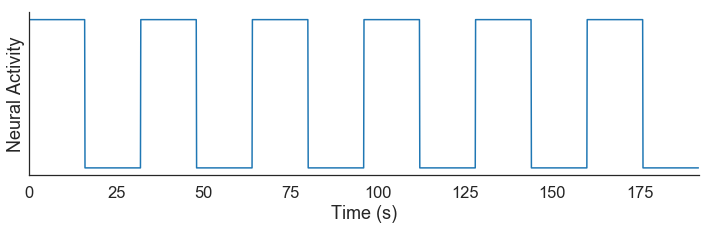

In [3]:
## Define experiment events.
events = [(0,16),(32,48),(64,80),(96,112),(128,144),(160,176)]

## Generate boxcars.
boxcars = np.zeros_like(sst)
for onset, offset in events:
    boxcars[np.logical_and(sst >= onset, sst < offset)] = 1
    
## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(sst, boxcars);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

### [3] Define the HRF
In the previous class, we saw that that the hemodynamic response can be variable in shape. In this step, we define the expected shape of the HRF. We typically fall back on early imaging experiments showing that, under many experimental conditions, the HRF has a stereotyped shape. This is the **SPM HRF**. 

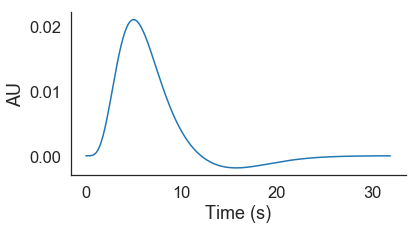

In [4]:
from fmritools.hrf import spm_hrf

## Define HRF.
hrf = spm_hrf(sfreq)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(sst[:hrf.size], hrf);
ax.set(xlabel='Time (s)', ylabel='AU')
sns.despine()

### [4] Convolution


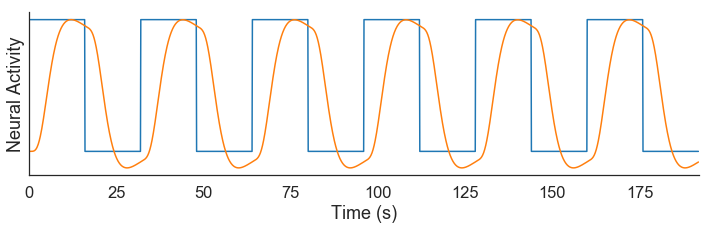

In [5]:
## Convolve boxcars + HRF.
bold = np.convolve(boxcars, hrf)[:sst.size]

## Normalize regressor.
bold /= bold.max()

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(sst, boxcars);
ax.plot(sst, bold);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

### [5] Downsampling

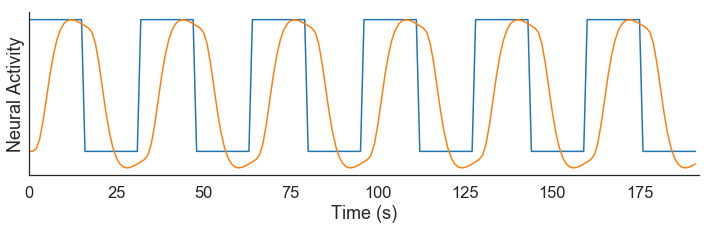

In [6]:
## Define observation times.
tr = 1
times = np.arange(n_times) * tr

## Define downsampling indices.
ix = np.in1d(sst, times)

## Downsampling.
boxcars = boxcars[ix]
bold = bold[ix]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, boxcars);
ax.plot(times, bold);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

## Part 1.5: Simple Regression

### [1] Load and visualize data

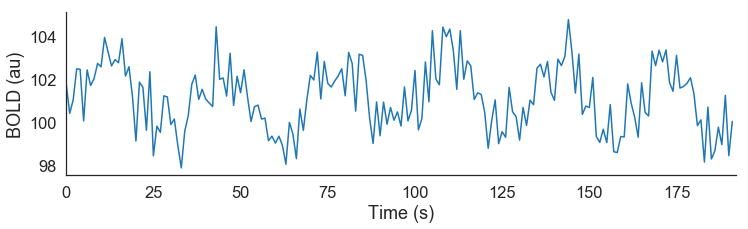

In [7]:
## Load and extract data.
npz = np.load('fmri-02-regression.npz')
times = npz['times']
y = npz['y']

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y);
ax.set(xlim=(0,192), xlabel='Time (s)', ylabel='BOLD (au)')
sns.despine()

### [2] Construct design matrix

In [8]:
X = np.column_stack([np.ones_like(bold), bold])

### [3] Regression

mu = 2.496


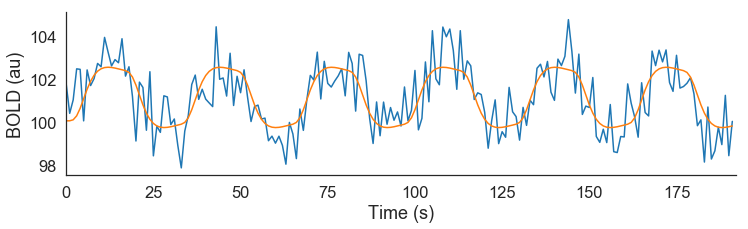

In [9]:
## Perform regression.
b, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
print('mu = %0.3f' %b[-1])

## Posterior predictive check.
yhat = X @ b

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y);
ax.plot(times, yhat);
ax.set(xlim=(0,192), xlabel='Time (s)', ylabel='BOLD (au)')
sns.despine()